# Remote computing with Perceval

Here we aim at showing how to connect to Quandela's cloud services to perform computation with real QPU and simulators remotely. We are going to use a simple two modes circuit here.

In [1]:
import time

from tqdm.notebook import tqdm

import perceval as pcvl
from perceval.algorithm import Sampler
from perceval.serialization import deserialize

import numpy as np

First, define your objects through Perceval as usual.

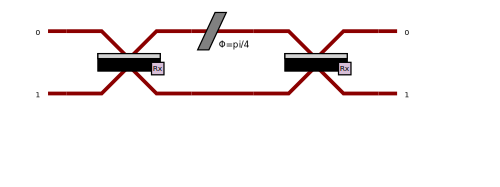

In [2]:
input_state = pcvl.BasicState([1, 1])

c = pcvl.Circuit(2)
c.add(0, pcvl.BS())
c.add(0, pcvl.PS(phi = np.pi/4))
c.add(0, pcvl.BS())

pcvl.pdisplay(c)

Now, visit cloud.quandela.com and login to see which QPU and simulators are available, as well as their specifications. Once you have chosen, all you have to do is to copy the machine's name. You can now define a `RemoteProcessor` using the name of the machine and your token. Before using your token, don't forget to give it the right to be used on the machine you want.

In [5]:
# Use your key here to let the system know who you are
token_qcloud = 'YOUR_API_KEY'
remote_simulator = pcvl.RemoteProcessor("sim:achernar", token_qcloud)

You can now access to the specificities of the machine directly in Perceval.

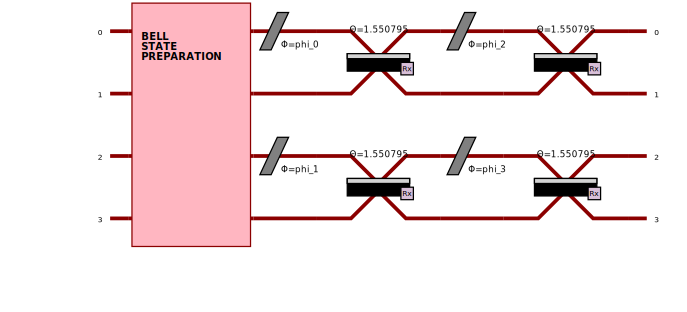

In [6]:
specs = remote_simulator.specs
pcvl.pdisplay(deserialize(specs["specific_circuit"]))

In [7]:
print(specs["accepted_input_states"])
print(specs["parameters"])

[':PCVL:BasicState:|1,0,0,0>', ':PCVL:BasicState:|1,0,1,0>', ':PCVL:BasicState:|1,0>', ':PCVL:BasicState:|1,1>']
{'HOM': 'indistinguishability value, using HOM model (default 1)', 'backend_name': 'name of the backend that will be used for computation (default "SLOS")', 'g2': 'g2 value (default 0)', 'mode_post_select': 'number of required detected modes to keep a state. Only used with 4 modes (default input_state.n)', 'phase_imprecision': 'imprecision on the phase shifter phases (default 0)', 'phi': 'phase shifter phases to set if no circuit is defined (default None)', 'position': 'Where to set the circuit or the phases. Only used with 2 modes. Possible values : "upper", "lower" (default "upper")', 'theta': 'beam splitters phases, seven values. None to use real chip phases (default None)', 'transmittance': 'probability at each pulse that a photon is sent to the system and is detected (default 1)'}


Now we have to specify what parameters we want to give to compute. For specific parameters, we have to use a special `set_parameter` function (or `set_parameters`).

In [8]:
remote_simulator.set_circuit(c)
remote_simulator.with_input(input_state)

remote_simulator.mode_post_selection(0)  # equivalent to remote_simulator.set_parameter("mode_post_select", 0)
remote_simulator.set_parameters({
    "HOM": .95,
    "transmittance": .1,
    "g2": .01
})

We can now use the `Sampler` with our `RemoteProcessor`.

In [15]:
sampler = Sampler(remote_simulator)

nsample = 10000
async_job = sampler.sample_count.execute_async(nsample)

The order has now been sent to a distant computer. As it is an async computation, we can do other things locally before the results arrive. In our case, we will just wait for the end of the computation. If you go to the cloud website again, you could see the job and its completion status.

In [16]:
previous_prog = 0
with tqdm(total=1, bar_format='{desc}{percentage:3.0f}%|{bar}|') as tq:
    tq.set_description(f'Get {nsample} samples from {remote_simulator.name}')
    while not async_job.is_complete:
        tq.update(async_job.status.progress/100-previous_prog)
        previous_prog = async_job.status.progress/100
        time.sleep(1)
    tq.update(1-previous_prog)
    tq.close()

print(f"Job status = {async_job.status()}")

  0%|          |

Job status = SUCCESS


Once the previous cell has stopped, the job is finished (again, you can see its status on the website). We can now retrieve the results to do some computation. Here, the computation should be relatively fast (unless the simulator is unavailable or there are many requests on it), so we can use the job object we created before. If the computation lasted for a long time, we could have created a new job object and directly retrieved the result given the job id that is visible on the website.

In [18]:
''' # To retrieve your job using a job id
remote_processor = pcvl.RemoteProcessor("sim_achernar", token_qcloud)
async_job = remote_processor.resume_job(id)
'''

results = async_job.get_results()
print(results["results"])

{
  |1,0>: 4950
  |1,1>: 80
  |0,1>: 4971
}
